# Duffing-stuffing parameter estimation

Goals:

  * Estimate parameters for a Duffing-like model such that it describes the behavior of the system with low error in different experimental schemes (varying resonnance frequencies, degradation, etc.).
  * Simulate the system and perform various analyses (sensitivity, stability, etc.)
  

## Table of contents

 1. [Empirical data](#empiric-data)
 2. [Model](#model)
 3. [Loss function](#loss-function)

In [1]:
%matplotlib notebook

import os
import numpy as np
import random
import itertools
from tqdm import tqdm_notebook as tqdm
from toolz import curry
from scipy import signal
from scipy.optimize import minimize
from scipy.io import loadmat

# PyDSTool requires scipy 0.X
# However, solve_ivp was introduced in scipy 1.X.
from scipy.integrate import odeint, solve_ivp
#from pydstool_integrator import simulate as ds_simulate

import matplotlib.pyplot as plt
#from matplotlib import animation
#plt.rcParams["animation.html"] = "jshtml"

<a name="empiric-data"></a>
## Empirical data

Data is measured through frequency scans at lab.

Read data from `.mat`-files as a dict of numpy arrays. We focus primarily on the XY-trace data, containing a stable-state period of 100 observations per frequency, for 5 experiments total with variying resonnance frequencies.

In [2]:
def read_xy(matfile, experiment_no):
    """Experiment number in [0, 5]"""
    xy = loadmat(matfile)['XYPost'][0, experiment_no]
    print("Variables (rows x observations): ", xy.dtype.names)
    xy_data = dict([(k, xy[i]) for i, k in enumerate(xy.dtype.names)])
    t_min, t_max = xy_data['t'][0,0], xy_data['t'][-1,0]
    f_min, f_max = xy_data['f'][0,0], xy_data['f'][-1,0]
    print("Resonnance frequencies: (%d, %d)" % (xy_data['XResfFreq'][0,0], xy_data['YResfFreq'][0,0]))
    print("Resonnance amplitudes: (%.2f, %.2f)" % (xy_data['XResAmp'][0,0], xy_data['YResAmp'][0,0]))
    print("T = %.2f" % (t_max - t_min,))
    print("t in [%.2f, %.2f]" % (t_min, t_max))
    print("f in [%.1f, %.1f]" % (f_min, f_max))
    print("x shape: %d x %d" % xy_data['x'].shape)
    print("y shape: %d x %d" % xy_data['y'].shape)
    return xy_data


def read_amp(matfile):
    ds_name = os.path.splitext(os.path.basename(matfile))[0]
    print("Reading ds '%s'" % ds_name)
    amp = loadmat(matfile)[ds_name]
    _, n_vars = amp.shape
    amp_data = dict([(amp[0,i][1][0][0][0],  amp[0,i][0][:,0]) for i in range(n_vars)])
    print("Variables: %s" % ','.join(amp_data.keys()))
    return amp_data

In [3]:
# Read first experiment
print("Reading first experiment")
xy_data = read_xy('data/XYPost.mat', 0)

Reading first experiment
Variables (rows x observations):  ('x', 'y', 's', 'f', 'v', 't', 'XResAmp', 'XResfFreq', 'YResAmp', 'YResfFreq')
Resonnance frequencies: (7600, 8100)
Resonnance amplitudes: (1.03, 1.10)
T = 55.78
t in [0.00, 55.78]
f in [0.0, 10000.0]
x shape: 101 x 100
y shape: 101 x 100


In [4]:
#amp_pre = read_amp('data/APre.mat')
#amp_post = read_amp('data/APost.mat')
#amp_postb = read_amp('data/APostB.mat')

#### Plotting

Three types of plots:

  * Frequency scan with amplitude mean/std.
  * Trajectory plot in (x, y)-plane.
  * Trajectory over time for x and y.

In [5]:
def plot_std_freqscan(xy_data):
    linewidth = 0.6
    fig, (ax11, ax12) = plt.subplots(
        nrows=1,
        ncols=2,
        figsize=(8, 4)
    )
    rows = list(filter(
        lambda r: xy_data['f'][r,0] != 0,
        range(xy_data['f'].shape[0])
    ))
    ax11.errorbar(
        xy_data['f'][rows,0],
        np.mean(xy_data['x'][rows, :], axis=1),
        np.std(xy_data['x'][rows, :], axis=1),
        linewidth=linewidth
    )
    ax11.axvline(x=xy_data['XResfFreq'][0,0], linestyle='--', color='red', linewidth=0.8)
    ax11.axvline(x=xy_data['YResfFreq'][0,0], linestyle='--', color='red', linewidth=0.8)
    ax11.set_xlabel(r'$f$')
    ax11.set_ylabel(r'$x$')
    ax12.errorbar(
        xy_data['f'][rows,0],
        np.mean(xy_data['y'][rows, :], axis=1),
        np.std(xy_data['y'][rows, :], axis=1),
        linewidth=linewidth
    )
    ax12.axvline(x=xy_data['XResfFreq'][0,0], linestyle='--', color='red', linewidth=0.8)
    ax12.axvline(x=xy_data['YResfFreq'][0,0], linestyle='--', color='red', linewidth=0.8)
    ax12.set_xlabel(r'$f$')
    ax12.set_ylabel(r'$y$')
    plt.suptitle("Amplitude mean and standard deviation per frequency\nRed lines are resonnance frequencies")
    #plt.tight_layout()
    
    
def plot_xy(rows, xy_data):
    linewidth = 0.6
    fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(
        nrows=2,
        ncols=2,
        figsize=(8, 6)
    )
    for row in rows:
        ax11.plot(xy_data['x'][row, :], linewidth=linewidth)
        ax12.plot(xy_data['y'][row, :], linewidth=linewidth)
        ax21.plot(xy_data['x'][row, :], xy_data['y'][row, :], linewidth=linewidth)
        ax22.plot(xy_data['f'][row, :])
        
    ax11.set_ylabel(r'$x$')
    ax12.set_ylabel(r'$y$')
    ax21.set_xlabel(r'$x$')
    ax21.set_ylabel(r'$y$')
    ax22.set_ylabel(r'$f$')
    plt.suptitle("XY-data plots for given frequencies")
    #plt.tight_layout()
    
    
def plot_xyt(rows, xy_data, normalizer=lambda x: x, sim_xy_data=None):
    N = len(rows)
    linewidth = 0.6
    fig, axes = plt.subplots(
        nrows=N,
        ncols=2,
        #sharey=True,
        #sharex=True,
        figsize=(8, 3*N)
    )
    for i in range(N):
        axes[i,0].plot(normalizer(xy_data['x'][rows[i], :]), linewidth=linewidth)
        axes[i,1].plot(normalizer(xy_data['y'][rows[i], :]), linewidth=linewidth)
        if sim_xy_data is not None:
            axes[i,0].plot(normalizer(sim_xy_data['x'][rows[i], :]), linewidth=linewidth)
            axes[i,1].plot(normalizer(sim_xy_data['y'][rows[i], :]), linewidth=linewidth)
        axes[i,0].set_ylabel('$x$ ($f$=%d)' % xy_data['f'][rows[i], 0])
        axes[i,1].set_ylabel('$y$ ($f$=%d)' % xy_data['f'][rows[i], 0])
    plt.suptitle("Stable-state XY-data plots for given frequencies")
    #plt.tight_layout()

Variables (rows x observations):  ('x', 'y', 's', 'f', 'v', 't', 'XResAmp', 'XResfFreq', 'YResAmp', 'YResfFreq')
Resonnance frequencies: (7600, 8100)
Resonnance amplitudes: (1.03, 1.10)
T = 55.78
t in [0.00, 55.78]
f in [0.0, 10000.0]
x shape: 101 x 100
y shape: 101 x 100


<IPython.core.display.Javascript object>


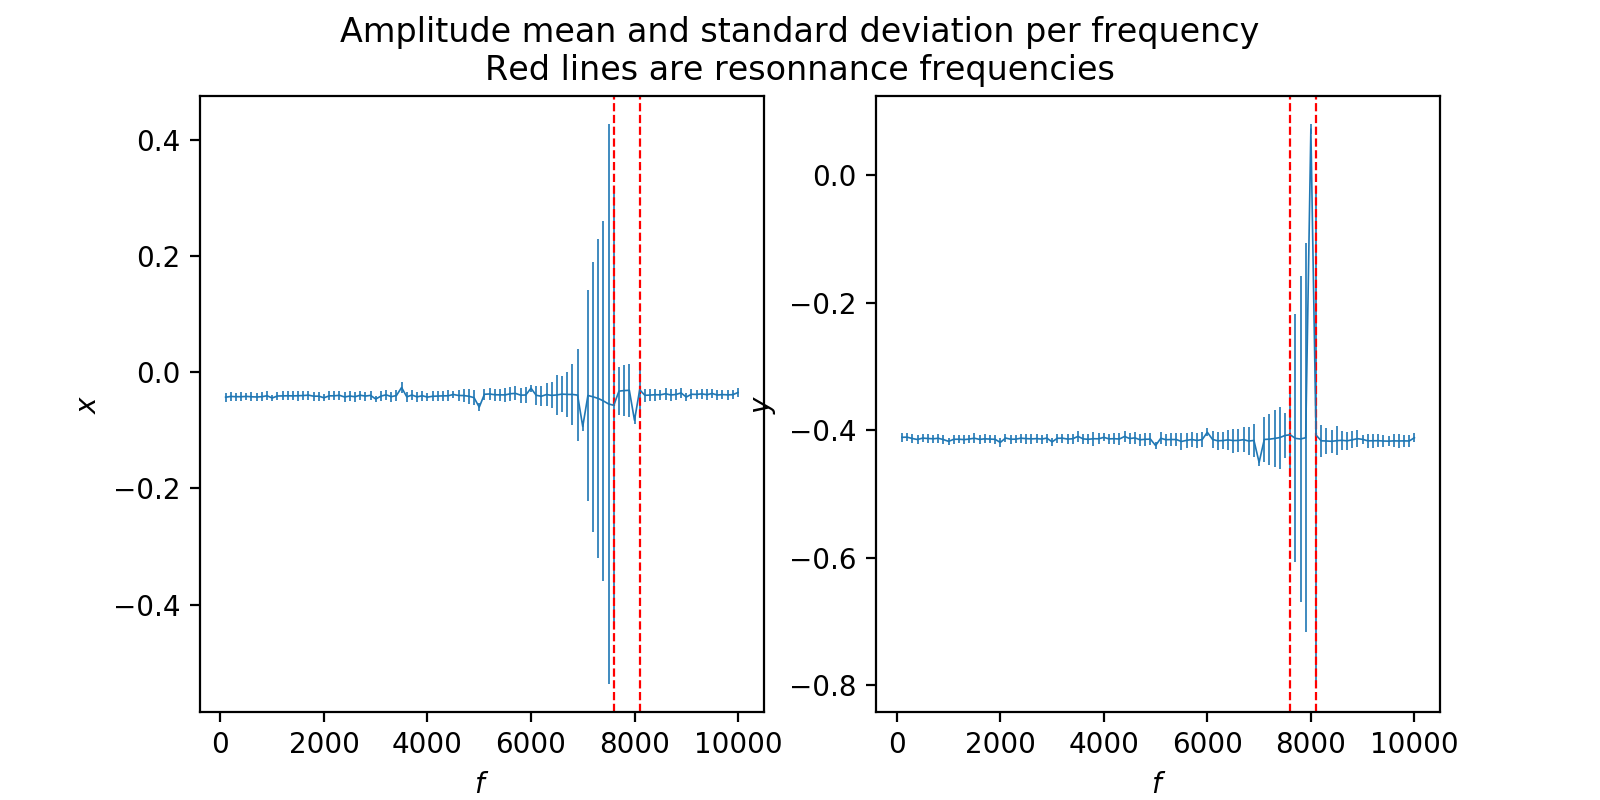

<IPython.core.display.Javascript object>


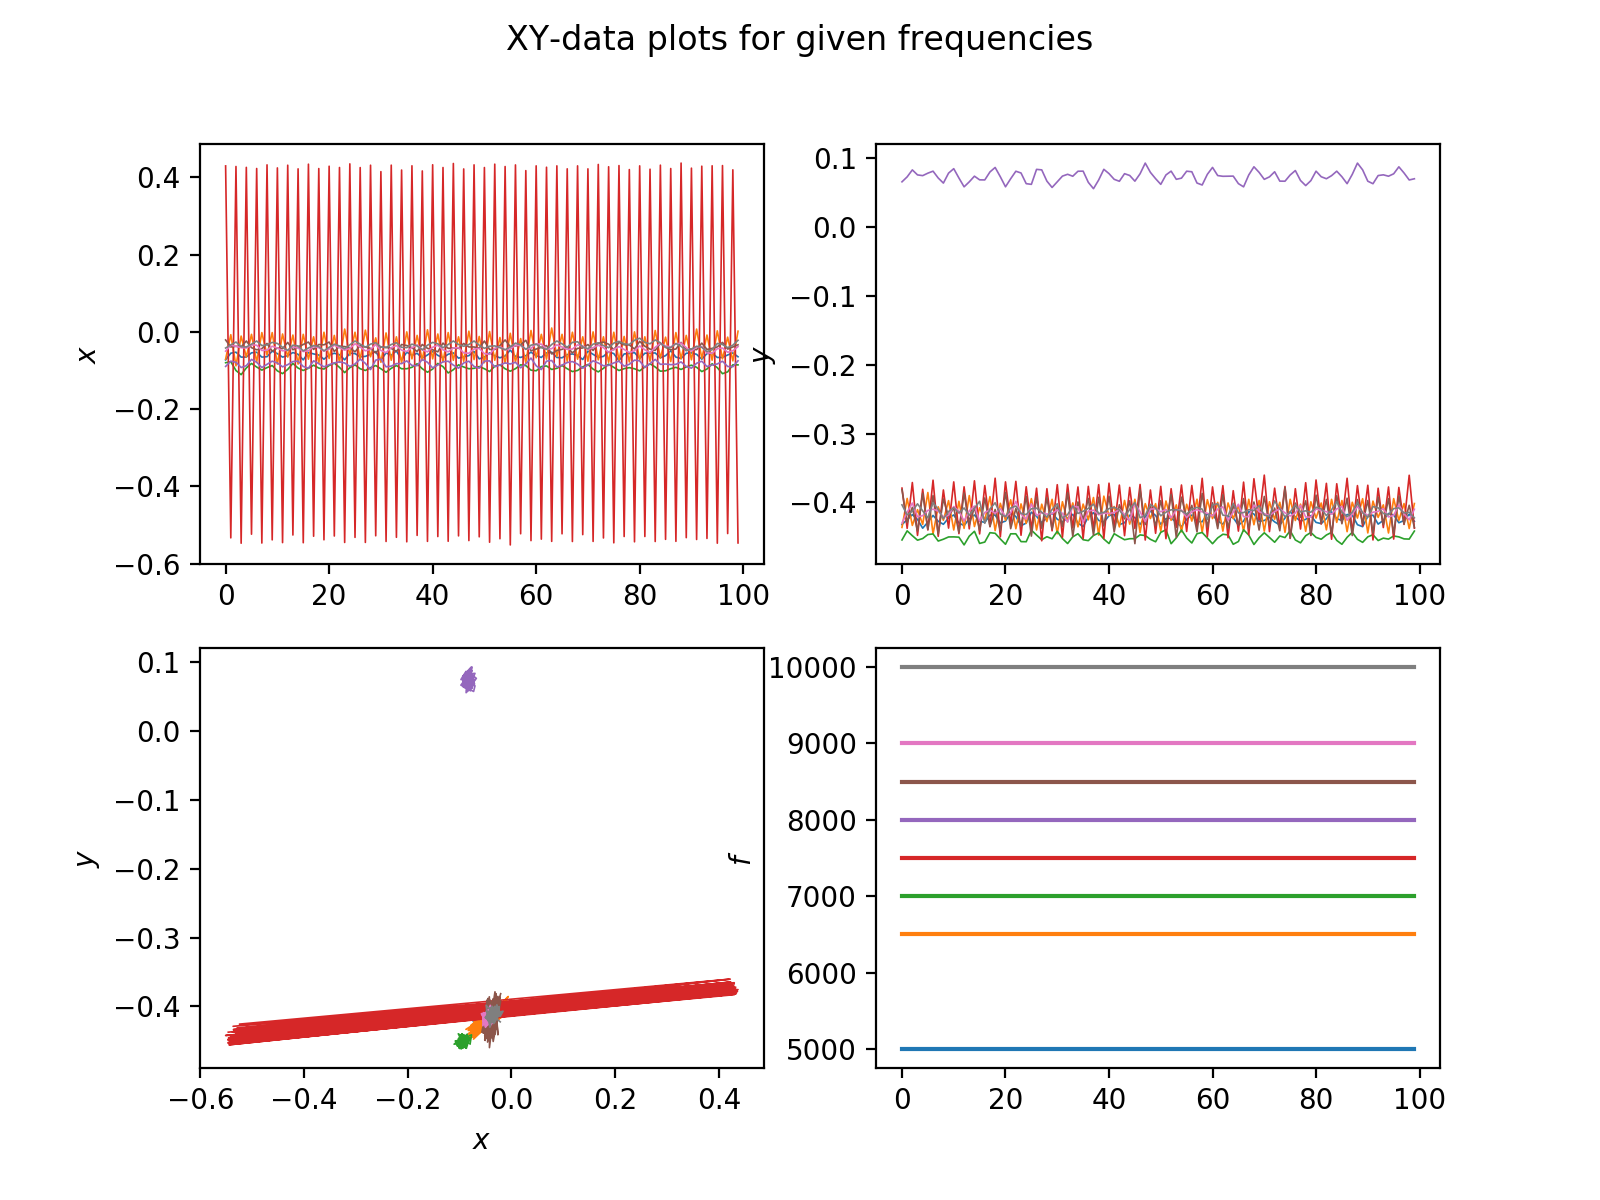

<IPython.core.display.Javascript object>


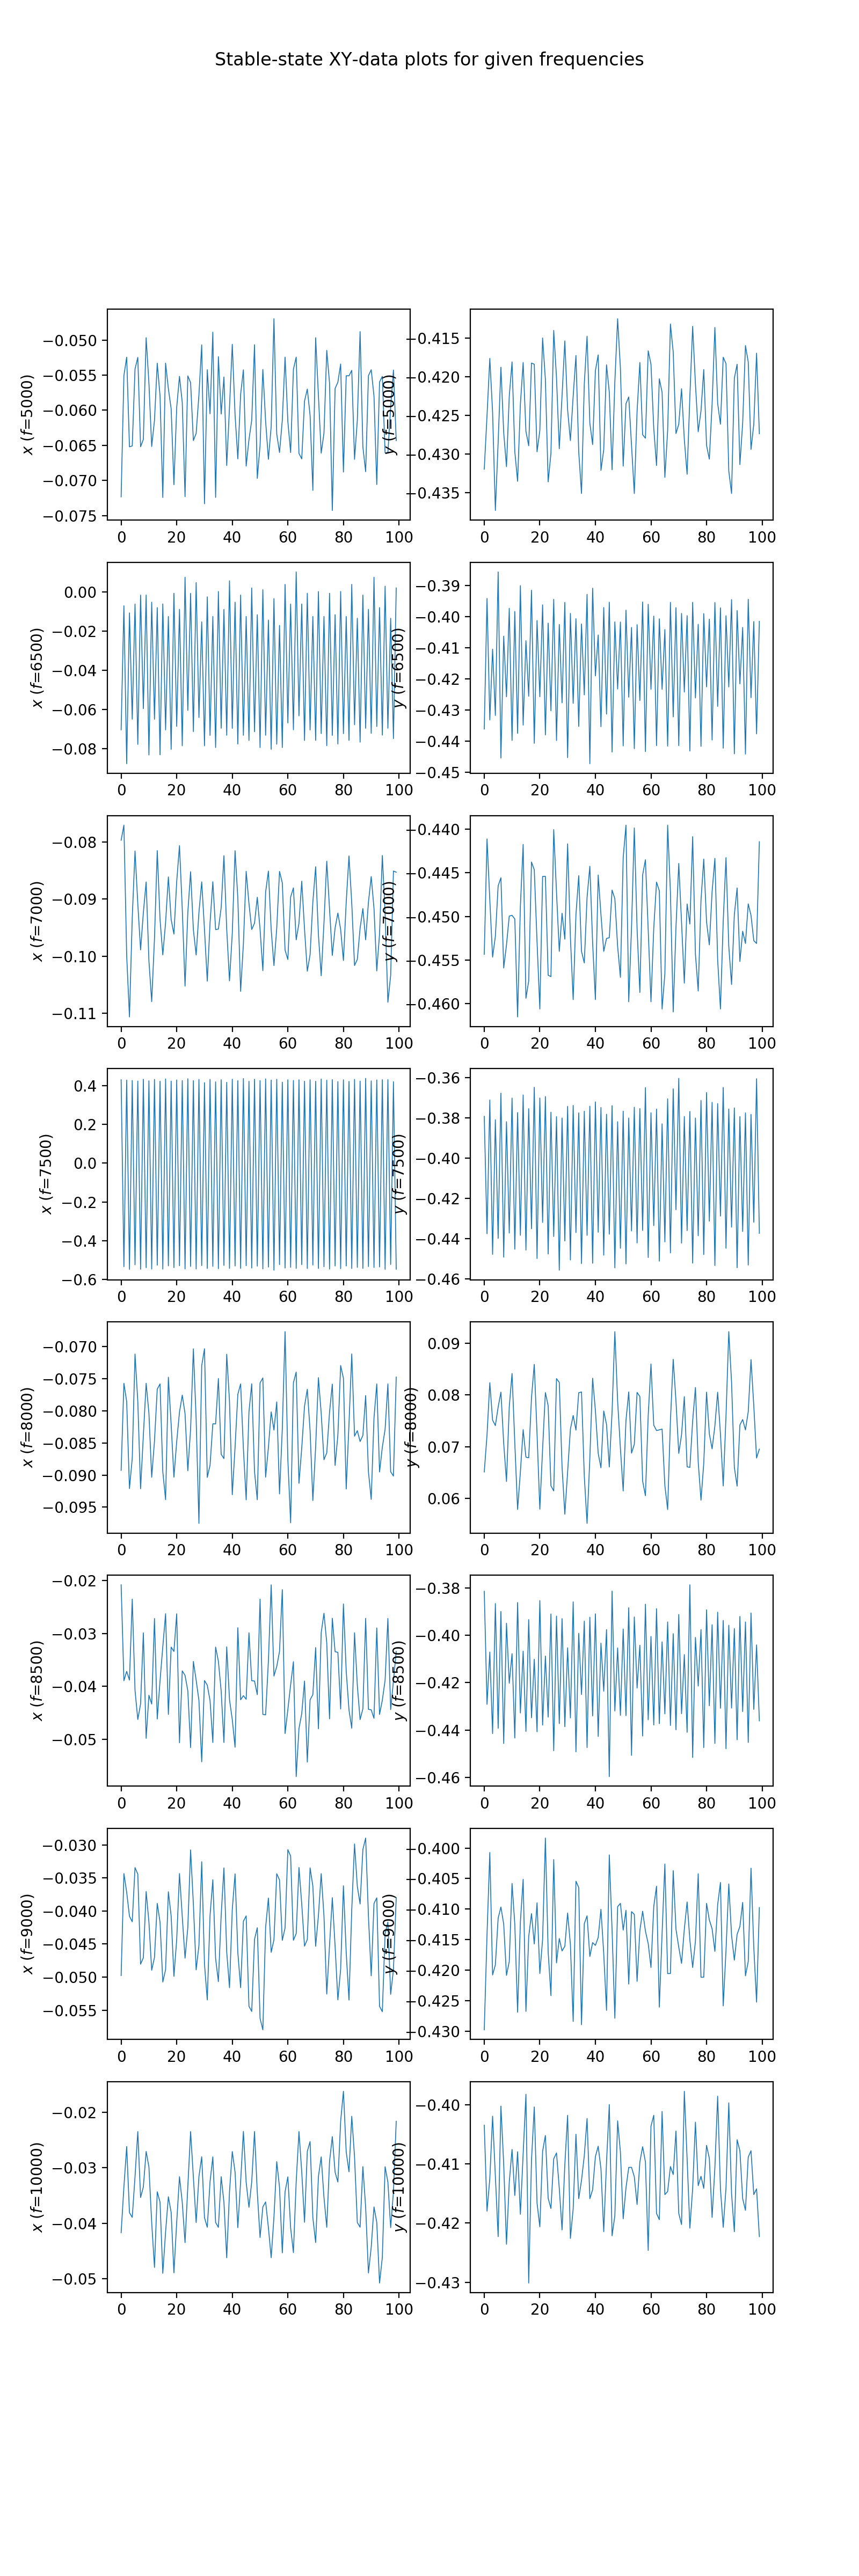

In [6]:
# Plot freqency scans (mean +- variation)
rows = [50, 65, 70, 75, 80, 85, 90, 100]
for exp_no in range(5):
    xy_data = read_xy('data/XYPost.mat', exp_no)
    plot_std_freqscan(xy_data)
    plot_xy(rows, xy_data)
    plot_xyt(rows, xy_data)
    break

<a name="model"></a>
## Model

Model derived from Duffing equations:

\begin{align}
m_1 \ddot{y}_1 &= F_1 - \dot{y}_1(c_1 + c_3) + \dot{y}_2c_3 - y_1(k_1 + k_3) + y_2k_3 - \alpha_1y_1^3 + \alpha_3(y_2 - y_1)^3 \\
m_2 \ddot{y}_2 &= F_2 - \dot{y}_2(c_2 + c_3) + \dot{y}_1c_3 - x_2(k_2 + k_3) + y_1k_3 - \alpha_2y_2^3 + \alpha_3(y_2 - y_1)^3 \\
\end{align}

where $F = Ce^{i\omega t}$. Transform to first-order form by variable substitutions $x_3 = \dot{y}_1, x_1 = y_1$ and $x_4 = \dot{y}_2, x_2 = y_2$:

\begin{align}
\dot{x}_1 &= x_3 \\
\dot{x}_2 &= x_4 \\
m_1\dot{x}_3 &= F_1 - x_3(c_1 + c_3) + x_4c_3 - x_1(k_1 + k_3) + x_2k_3 - \alpha_1x_1^3 + \alpha_3(x_2 - x_1)^3 \\
m_2\dot{x}_4 &= F_2 - x_4(c_2 + c_3) + x_3c_3 - x_2(k_2 + k_3) + x_1k_3 - \alpha_2x_2^3 + \alpha_3(x_2 - x_1)^3 \\
\end{align}


For some reason, this model doesn't work out when working backwards from resonnance frequencies. I may be missing something obvious, otherwise the fact that mass goes into the estimations may mess things up.


### Transformed model

Eliminate mass, + easier to reason about physical constants:

\begin{align}
\dot{x}_1 &= x_3 \\
\dot{x}_2 &= x_4 \\
\dot{x}_3 &= \frac{1}{m_1}F_1 - x_3(c_1 + c_3) + x_4c_3 - x_1(k_1 + k_3) + x_2k_3 - \alpha_1x_1^3 + \alpha_3(x_2 - x_1)^3 \\
\dot{x}_4 &= \frac{1}{m_2}F_2 - x_4(c_2 + c_3) + x_3c_3 - x_2(k_2 + k_3) + x_1k_3 - \alpha_2x_2^3 + \alpha_3(x_2 - x_1)^3 \\
\end{align}

With the Jacobian $\mathbf{J} = \frac{\partial \mathbf{f}}{\partial \mathbf{X}}$

\begin{bmatrix}
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
-k_1 - k_3 - 3\alpha_1x_1^2 - 3\alpha_3(x_2 - x_1)^2 & k_3 + 3\alpha_3(x_2 - x_1)^2 & -c_1 - c_3 & c_3 \\
k_3 - 3\alpha_3(x_2 - x_1)^2 & -k_2 - k_3 - 3\alpha_2x_2^2 + 3\alpha_3(x_2 - x_1)^2 & c_3 & -c_2 - c_3
\end{bmatrix}

Use the harmonic oscillator identities

  * Undamped angular frequency:

\begin{align}
\omega_0 &= \sqrt{\frac{k}{m}}
\end{align}

  * Damping ratio:

\begin{align}
\zeta &= \frac{c}{2\sqrt{mk}}
\end{align}

  * Resonant freqency:

\begin{align}
\omega_r &= \omega_0\sqrt{1-2\zeta^2}, \zeta < \frac{1}{\sqrt{2}}
\end{align}

and express the constants subject to estimation as

\begin{align}
c_1 &= 2 \zeta_1 \omega_{0,1} \\
c_2 &= 2 \zeta_2 \omega_{0,2} \\
c_3 &= g_c(c_1, c_2) \\
k_1 &= \omega_{0,1}^2 \\
k_2 &= \omega_{0,2}^2 \\
k_3 &= g_k(k_1, k_2) \\
\alpha_1 &= f_1(\mathbf{X} ; \theta) \\
\alpha_2 &= f_2(\mathbf{X} ; \theta) \\
\alpha_3 &= g_{\alpha}(\alpha_1, \alpha_2)
\end{align}


With the model expressed this way, things make sense and we get resonnance where it should be.


### Notes on solvers

  * We use SciPy's `solve_ivp` to simulate the system. Different methods (RK45, LSODA, Radeau) has been tested with no noticable differences.
  * The standard `odeint` from SciPy is super shit. It easily diverges and is unstable. They claim to use the standard LSODA solver (same as `solve_ivp` with method='LSODA') but the results are entirely different.
  * Once we hit the right parameters, the simulation is considerable slower because these are adaptive solvers.
  * There is an ODE implementation from the [PyDSTool package](https://github.com/robclewley/pydstool) which compiles to C and is much much faster.
  
#### PyDSTool solver

The model is implemented with this solver. It's slightly faster, but notoriously more complicated to use. Besides, it requires SciPy version `<1.0` which is not compatible with the rest of this code. Let's stick to scipy's modern solvers.

In [7]:
@curry
def model1(omega, p, t, X):
    x1, x2, xd1, xd2 = X
    C1, C2, m1, m2, c1, c2, c3, k1, k2, k3, a1, a2, a3 = p
    F1 = C1*np.cos(omega*t)
    F2 = C2*np.cos(omega*t)
    xdd1 = F1 - xd1*(c1 + c3) + xd2*c3 - x1*(k1 + k3) + x2*k3 - a1*x1**3 + a3*(x2 - x1)**3
    xdd2 = F2 - xd2*(c2 + c3) + xd1*c3 - x2*(k2 + k3) + x1*k3 - a2*x2**3 + a3*(x2 - x1)**3
    return xd1, xd2, m1*xdd1, m2*xdd2

@curry
def model2(omega, p, t, X):
    x1, x2, xd1, xd2 = X
    C1, C2, m1, m2, c1, c2, c3, k1, k2, k3, a1, a2, a3 = p
    xdd1 = C1*np.cos(omega*t)/m1 - xd1*(c1 + c3) + xd2*c3 - x1*(k1 + k3) + x2*k3 - a1*x1**3 + a3*(x2 - x1)**3
    xdd2 = C2*np.cos(omega*t)/m2 - xd2*(c2 + c3) + xd1*c3 - x2*(k2 + k3) + x1*k3 - a2*x2**3 + a3*(x2 - x1)**3
    return xd1, xd2, xdd1, xdd2

@curry
def jacobian2(omega, p, t, X):
    x1, x2, xd1, xd2 = X
    C1, C2, m1, m2, c1, c2, c3, k1, k2, k3, a1, a2, a3 = p
    return np.array([
        [             0                   ,            0                      ,     1   ,   0   ],
        [             0                   ,            0                      ,     0   ,   1   ],
        [-k1-k3-3*a1*x1**2-3*a3*(x2-x1)**2,    k3+3*a3*(x2-x1)**2             ,  -c1-c3 ,   c3  ],
        [    k3-3*a3*(x2-x1)**2           , -k2-k3-3*a2*x2**2+3*a3*(x2-x1)**2 ,     c3  , -c2-c3]
    ])

def odeint_integrate(model, jac, dt, T, X0, rtol, atol):
    t = np.linspace(0, T, int(T/dt))
    X = odeint(model, X0, t, Dfun=jac, tfirst=True, rtol=rtol, atol=atol)
    return X.T

def solve_ivp_integrate(model, jac, dt, T, X0, rtol, atol):
    t = np.linspace(0, T, int(T/dt))
    sol = solve_ivp(model, [0, T], X0, t_eval=t, jac=jac, method='Radau', first_step=dt, rtol=rtol, atol=atol)
    return sol.y

# Rely on the same functional signatures by mimicing the data structure of lab measurement.
def simulate_xy_data(integrator, rows, xy_data, T, t_trans, t_scale, steps, x0, v0, p, progress=True):
    sim_xy_data = {
        'x': np.zeros((101, 100)),
        'y': np.zeros((101, 100)),
        'f': np.zeros((101, 100)),
        'XResfFreq': xy_data['XResfFreq'],
        'YResfFreq': xy_data['YResfFreq']
    }
    _rows = tqdm(rows) if progress else rows
    for i in _rows:
        f = xy_data['f'][i,0]
        omega = 2*np.pi*f/t_scale
        X = integrator(
            model2(omega, p),
            jacobian2(omega, p),
            (T-t_trans)/steps,
            T,
            x0 + v0,
            1e-3,
            [1e-4, 1e-4, 1e-2, 1e-2]
        )
        x1, x2, xd1, xd2 = X
        sim_xy_data['x'][i,:] = x1[-steps:]
        sim_xy_data['y'][i,:] = x2[-steps:]
        sim_xy_data['f'][i,:] = f
    return sim_xy_data

def simulate_experiment(xy_data, rows, zeta1, zeta2, gc, gk, ga, f1, f2, verbose=True):
    # Amplitude at resonnance should be 1
    # Aim for better numerical stability by setting C and m to approx. the same numeric precision
    t_scale = 1
    C1 = 1e7/t_scale
    C2 = 1e7/t_scale
    m1 = 1
    m2 = 1

    # Fetch resonnance frequencies from data
    f_r1 = xy_data['XResfFreq']/t_scale
    f_r2 = xy_data['YResfFreq']/t_scale
    omega_r1 = 2*np.pi*f_r1
    omega_r2 = 2*np.pi*f_r2
    #omega_01 = omega_r1/(np.sqrt(1-2*zeta1**2))
    #omega_02 = omega_r2/(np.sqrt(1-2*zeta2**2))

    # Compute parameters from identities
    #c1 = 2*zeta1*omega_01
    #c2 = 2*zeta2*omega_02
    c1 = 200
    c2 = 200
    c3 = gc(c1, c2)
    k1 = omega_r1**2
    k2 = omega_r2**2
    k3 = gk(k1, k2)
    #a1 = f1(k1, k2)
    #a2 = f2(k1, k2)
    #a3 = ga(k1, k2)
    a1 = 1e8
    a2 = 1e8
    a3 = 0

    p = (
        C1, C2,
        m1, m2,
        c1, c2, c3,
        k1, k2, k3,
        a1, a2, a3
    )

    if verbose:
        print("Parameters:")
        print("Omega_r 1 = %.3f" % omega_r1)
        print("Omega_r 2 = %.3f" % omega_r2)
        #print("Omega0 1 = %.3f" % omega_01)
        #print("Omega0 2 = %.3f" % omega_02)
        print("c1 = %.3f" % c1)
        print("c2 = %.3f" % c2)
        print("c3 = %.3f" % c3)
        print("k1 = %.3f" % k1)
        print("k2 = %.3f" % k2)
        print("k3 = %.3f" % k3)
        print("a1 = %.3f" % a1)
        print("a2 = %.3f" % a2)
        print("a3 = %.3f" % a3)

    # Start from any state, the system stabilize quickly
    x0, v0 = (-0.002, 0.01), (-0.004, 0.03)
    #x0, v0 = (0.0, 0.0), (0.0, 0.0)
    
    # Set transient period to 0.1 seconds and simulate 100 steps over 0.5 seconds
    t_trans = 0.1*t_scale
    T = t_trans + 0.5*t_scale
    steps = 100

    # Simulate mostly around resonnance
    return simulate_xy_data(solve_ivp_integrate, rows, xy_data, T, t_trans, t_scale, steps, x0, v0, p, progress=verbose)

#### Harmonic oscillator

Set $c_3 = k_3 = \alpha_1 = \alpha_2 = \alpha_3 = 0$ for simulating a standard driven harmonic oscillator with no coupling between x- and y-components. Assume damping $\zeta_1 = \zeta_2 = 0.1$ and use resonnance frequencies from lab data to estimate parameters.

Read data, experiment 0
Variables (rows x observations):  ('x', 'y', 's', 'f', 'v', 't', 'XResAmp', 'XResfFreq', 'YResAmp', 'YResfFreq')
Resonnance frequencies: (7600, 8100)
Resonnance amplitudes: (1.03, 1.10)
T = 55.78
t in [0.00, 55.78]
f in [0.0, 10000.0]
x shape: 101 x 100
y shape: 101 x 100
Parameters:
Omega_r 1 = 47752.208
Omega_r 2 = 50893.801
c1 = 200.000
c2 = 200.000
c3 = 0.000
k1 = 2280273400.828
k2 = 2590178979.022
k3 = 0.000
a1 = 100000000.000
a2 = 100000000.000
a3 = 0.000


<IPython.core.display.Javascript object>


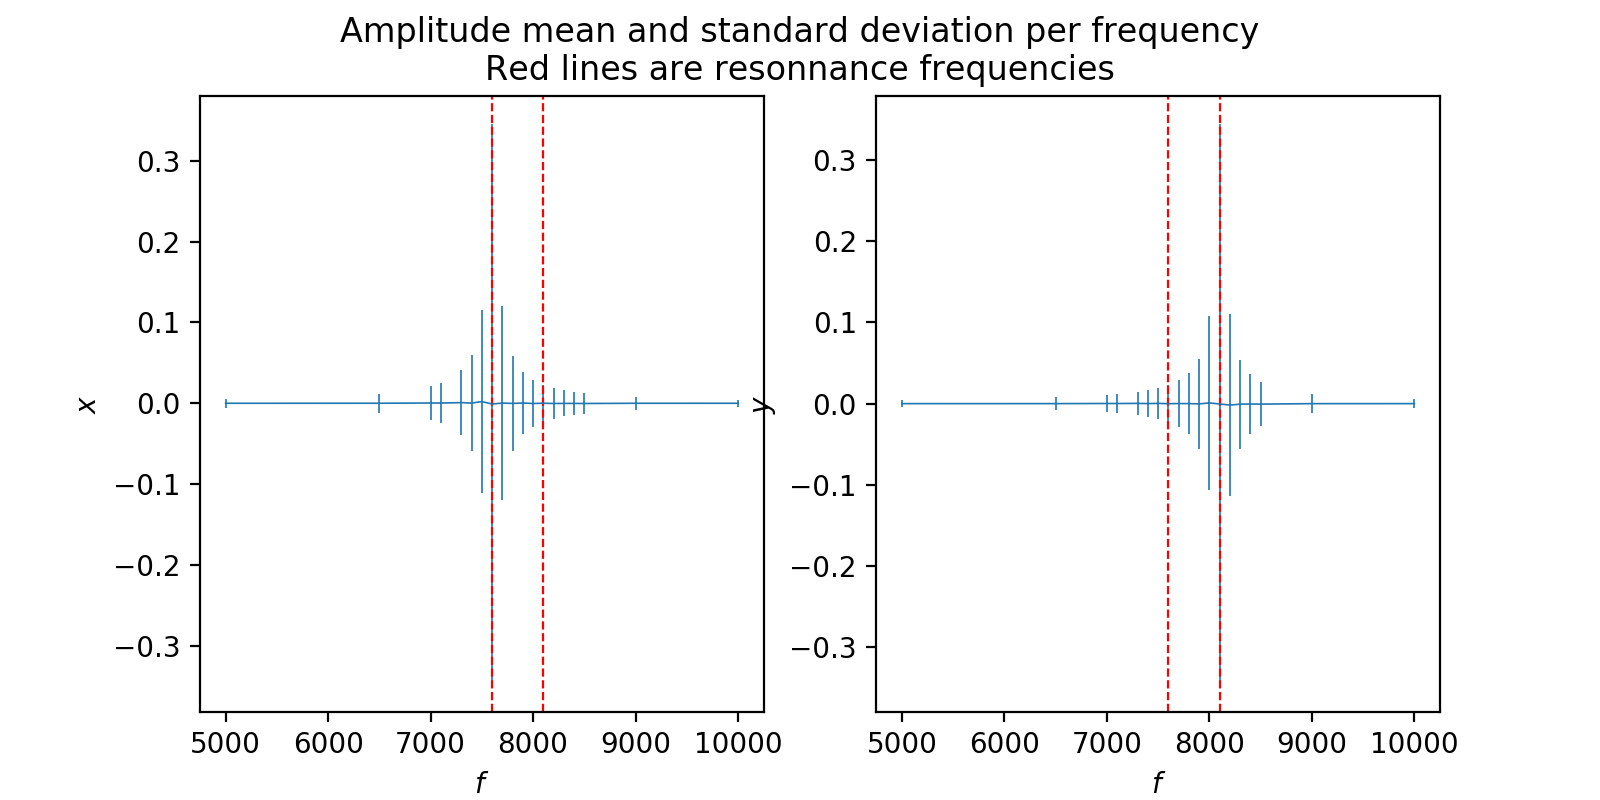

<IPython.core.display.Javascript object>


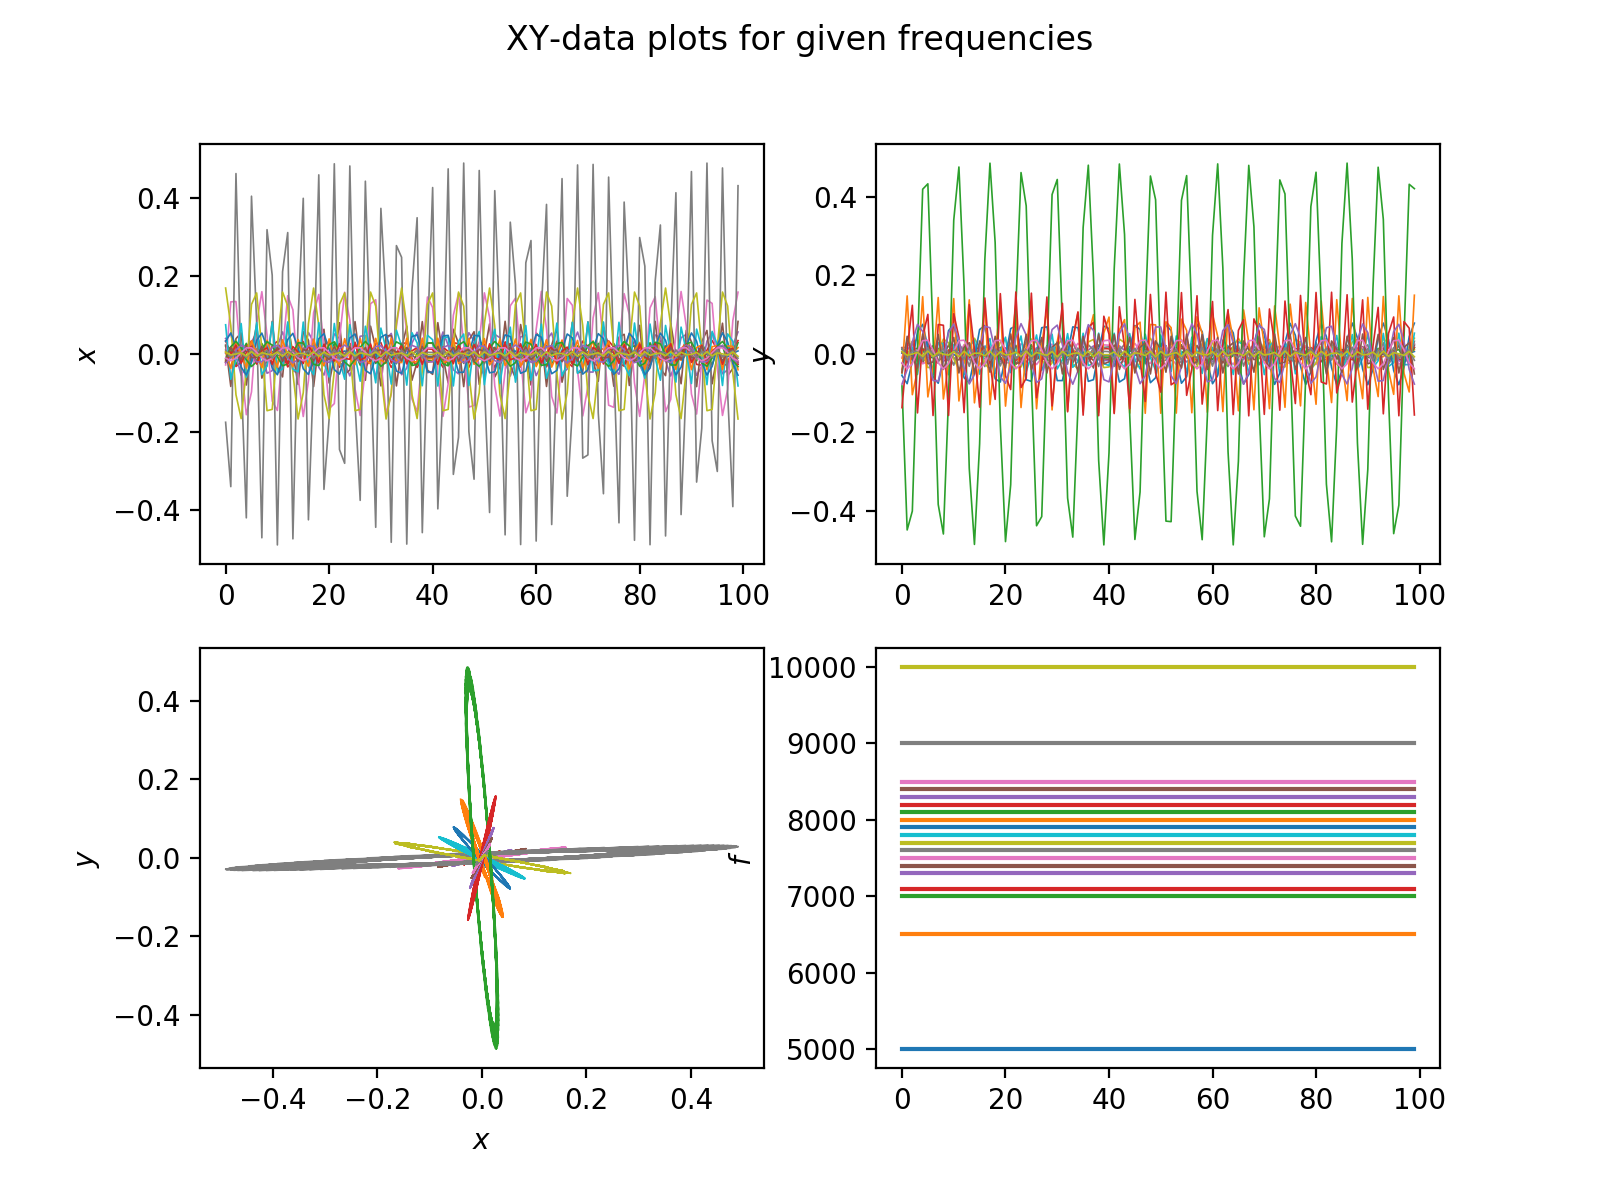

<IPython.core.display.Javascript object>


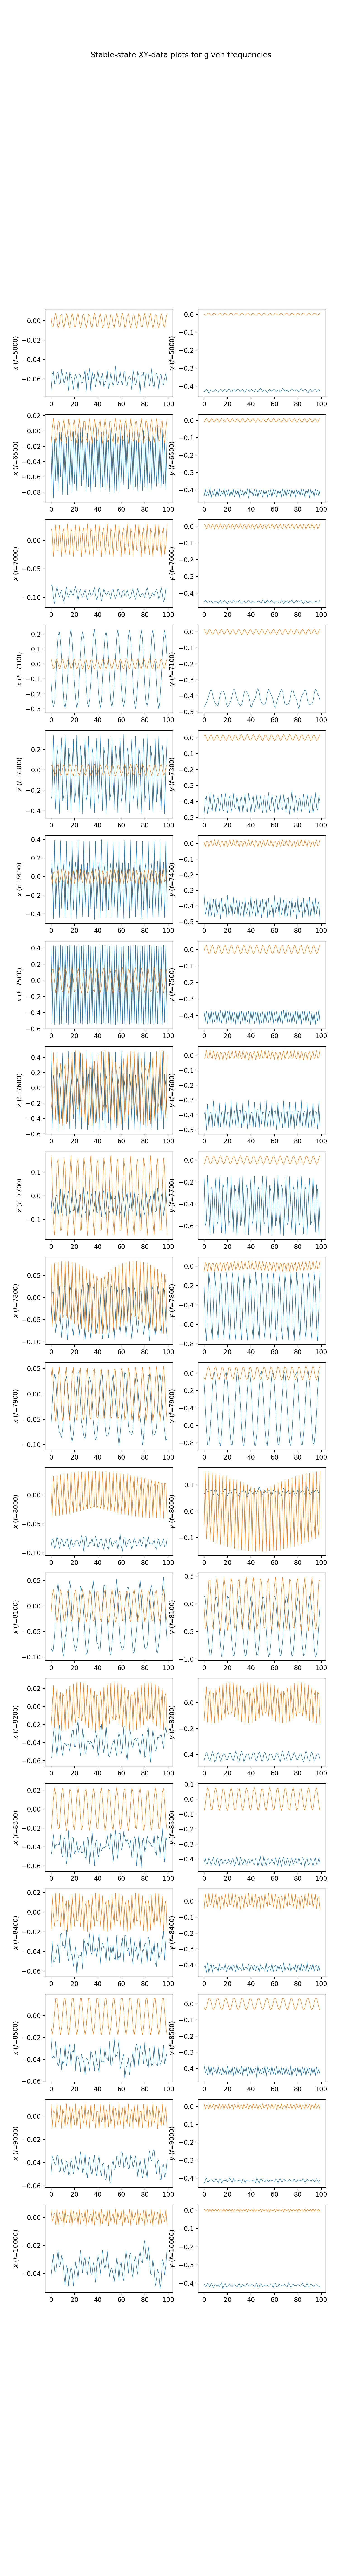

In [8]:
exp_no = 0
print("Read data, experiment %d" % exp_no)
xy_data = read_xy('data/XYPost.mat', exp_no)

def gc(c1, c2):
    return 0.0

def gk(k1, k2):
    return 0.0

def f1(k1, k2):
    return 0.0

def f2(k1, k2):
    return 0.0

def ga(k1, k2):
    return 0.0

rows = [50, 65, 70, 71, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 90, 100]
zeta1 = 0.1
zeta2 = 0.1
xyhat_data = simulate_experiment(xy_data, rows, zeta1, zeta2, gc, gk, ga, f1, f2, verbose=True)

plot_std_freqscan(xyhat_data)
plot_xy(rows, xyhat_data)
plot_xyt(rows, xy_data, sim_xy_data=xyhat_data)

#### With duffing term

The duffing term has to be pretty large to see any stiffening effect. Set $\alpha_1 = 1500k_1$ and $\alpha_2 = 1500k_2$ (still without coupling).

In [ ]:
exp_no = 0
print("Read data, experiment %d" % exp_no)
xy_data = read_xy('data/XYPost.mat', exp_no)

def gc(c1, c2):
    return 0.0

def gk(k1, k2):
    return 0.0

def f1(k1, k2):
    return 1.5e3*k1

def f2(k1, k2):
    return 1.5e3*k2

def ga(k1, k2):
    return 0.0

rows = [50, 65, 70, 75, 80, 85, 90, 100]
zeta1 = 0.1
zeta2 = 0.1
xyhat_data = simulate_experiment(xy_data, rows, zeta1, zeta2, gc, gk, ga, f1, f2, verbose=True)

plot_std_freqscan(xyhat_data)
plot_xy(rows, xyhat_data)
plot_xyt(rows, xy_data, sim_xy_data=xyhat_data)

#### With coupling

In [ ]:
exp_no = 0
print("Read data, experiment %d" % exp_no)
xy_data = read_xy('data/XYPost.mat', exp_no)

def gc(c1, c2):
    return 0.05*(c1 + c2)

def gk(k1, k2):
    return 0.05*(k1 + k2)

def f1(k1, k2):
    return 1.5e3*k1

def f2(k1, k2):
    return 1.5e3*k2

def ga(k1, k2):
    return 0.05*(a1 + a2)

rows = [50, 65, 70, 75, 80, 85, 90, 100]
zeta1 = 0.1
zeta2 = 0.1
xyhat_data = simulate_experiment(xy_data, rows, zeta1, zeta2, gc, gk, ga, f1, f2, verbose=True)

plot_std_freqscan(xyhat_data)
plot_xy(rows, xyhat_data)
plot_xyt(rows, xy_data, sim_xy_data=xyhat_data)

<a name="loss-function"></a>
## Loss function

Given the two multivariate signals, one empirical and one simulated, we need a distance metric $d(\mathbf{S}(\omega), \hat{\mathbf{S}}(\omega))$ that quantifies the error of our simulation.

Consider first a single frequency $\mathbf{S}(\omega=x) \in \mathbb{R}^2$. Treat each component individually, perform autocorrelation do find the shift, then simply use mean squared error as the distance metric between the two common periods of $\mathbf{S}$ and $\hat{\mathbf{S}}$. We extend this to the multivariate case by simply averaging the loss for each frequency.

TODO: Assert that both components of $\mathbf{S}(\omega=x)$ have the same shift.

In [ ]:
def normalize_signal(s):
    return (s - np.mean(s)) / np.std(s)

def autocorrelate_1d(s1, s2):
    corr = np.correlate(s1, s2, mode='same') / (np.linalg.norm(s1)*np.linalg.norm(s2))
    corr_half = corr[int(len(s1)/2):]
    idx = np.argmax(corr_half)
    return idx, corr_half[idx]

def loss_1d(s1, s2, normalize=True):
    assert len(s1) == len(s2)
    N = len(s1)
    if normalize:
        _s1 = normalize_signal(s1)
        _s2 = normalize_signal(s2)
    else:
        _s1 = s1
        _s2 = s2
    idx, coeff = autocorrelate_1d(_s1, _s2)
    return idx, coeff, np.mean((_s1[idx:]-_s2[:N-idx])**2)

def xy_loss(rows, xy_data, xyhat_data, normalize=True, verbose=False):
    # Calculate correlation coefficients and MSE for both x and y for the specified set of rows
    x_idxs, x_coeffs, x_mses = zip(*[loss_1d(xy_data['x'][i,:], xyhat_data['x'][i,:], normalize=normalize) for i in rows])
    y_idxs, y_coeffs, y_mses = zip(*[loss_1d(xy_data['y'][i,:], xyhat_data['y'][i,:], normalize=normalize) for i in rows])
    # Print some statistics
    if verbose:
        print('\n'.join(map(
            lambda var: "%s: %.4f mean, %.4f std" % (var[0], np.mean(var[1]), np.std(var[1])),
            [
                ('X idx', x_idxs),
                ('Y idx', y_idxs),
                ('X coeffs', x_coeffs),
                ('Y coeffs', y_coeffs),
                ('X MSEs', x_mses),
                ('Y MSEs', y_mses)
            ]
        )))
    # Return the sum of means of both components
    return np.mean(x_mses) + np.mean(y_mses)

#### Loss function test

Random signals and sines.

In [ ]:
# Test loss function
t = np.linspace(0, 100, 100)
s1 = {
    'f': np.array([
        np.ones((100,)),
        2*np.ones((100,))
    ]),
    'x': np.array([
        np.random.randn(100),
        np.array([1*np.sin(i/np.pi) for i in t]),
    ]),
    'y': np.array([
        np.random.randn(100),
        np.array([1*np.cos(i/np.pi) for i in t]),
    ])
}
s2 = {
    'f': np.array([
        np.ones((100,)),
        2*np.ones((100,))
    ]),
    'x': np.array([
        np.random.randn(100),
        np.array([1*np.cos(i/np.pi) for i in t]),
    ]),
    'y': np.array([
        np.random.randn(100),
        np.array([1*np.sin(i/np.pi) for i in t]),
    ])
}

plot_xyt([0,1], s1, sim_xy_data=s2)

print("Loss: %.4f\n" % xy_loss([0], s1, s2, verbose=True))
print("Loss: %.4f\n" % xy_loss([1], s1, s2, verbose=True))
print("Loss: %.4f" % xy_loss([0, 1], s1, s2, verbose=True))

#### Loss for model

Plotting normalized signals.

In [ ]:
print("Loss: %.4f\n" % xy_loss(rows, xy_data, xyhat_data, verbose=True))
plot_xyt(rows, xy_data, normalizer=normalize_signal, sim_xy_data=xyhat_data)

In [ ]:
#C_grid = [1e1] # Amplitude of driving force (gamma)
#c_grid = [1e2] # Damping (delta)
#a_grid = [1e-1] # Non-linear restoring force (beta)
#k_grid = [1e6] # Linear stiffness (alpha)

#xy_data = read_xy('data/XYPost.mat', 0)
#rows = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
#rows = [10, 65, 70, 75, 80, 85, 90]

#losses = []
#best_loss = 1e9
#best_p = None
#for c, a, k, C in tqdm.tqdm(itertools.product(*[c_grid, a_grid, k_grid, C_grid])):
#    print("c1=c2=c3=%.4f, a1=a2=a3=%.4f, k1=k2=k3=%.4f, C1=C2=%.4f" % (c, a, k, C))
#    _damping = 0.001
#    _omegar = 8e3
#    _omega0 = _omegar/(np.sqrt(1-2*_damping**2))
#    C = 1e5
#    c2 = 2*_damping*_omega0
#    k2 = _omega0**2
#    a = 0.5
#    p = (C, C, 0.03*c2, c2, 0.01*c2, 0.01*a, 0.9*a, 0.02*a, 0.5*k2, k2, 0.1*k2)
#    #p = (C, C, c, c, c, a, a, a, k, k, k)
#    xyhat_data = simulate_xy_data(rows, xy_data, p)
#    loss = xy_loss(rows, xy_data, xyhat_data, verbose=True)
#    losses.append(loss)
#    if loss < best_loss:
#        best_loss = loss
#        best_p = p
#    print("Loss: %.4f\n" % loss)
#    plot_xyt(rows, xy_data, sim_xy_data=xyhat_data)
#    break

In [ ]:
@curry
def objective(omega, p):
    obj = 0.0
    # Simulate and return MSE(xy_data, sim_xy_data)
    return obj

p0 = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1)
bounds = [
    (0.1, 0.2),
    (0.1, 0.2),
    (0.1, 0.2),
    (0.1, 0.2),
    (0.1, 0.2),
    (0.1, 0.2),
    (0.1, 0.2),
    (0.1, 0.2),
    (0.1, 0.2)
]
#omegas = xy_data['f'][:,0].tolist()
#solution = minimize(objective(omega), p0, method='SLSQP', bounds=bounds)
#p = solution.x

# Simulate with updated values
#t, X, dt, pstep = model(T, t_trans, dt_per_period, x0, v0, omega, p)